# Institute-only Earnings Model
Predict MD_EARN_WNE_P10 using institution features, compare classifiers for VALUE_LABEL, and rank colleges with user weights.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from IPython.display import display



## Data paths
Adjust if your CSVs live elsewhere.


In [3]:

CANDIDATE_INSTITUTION = [
    "institute_level_processed_most_recent.csv",
]

def pick_path(candidates):
    for p in candidates:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"None of these paths exist: {candidates}")

DATA_PATH = pick_path(CANDIDATE_INSTITUTION)
print("Using DATA_PATH:", DATA_PATH)



Using DATA_PATH: institute_level_processed_most_recent.csv


## Load data, define target/label, and feature sets
- Target: `MD_EARN_WNE_P10`
- VALUE_LABEL: affordable + high quality
- Separate feature sets to avoid leakage in classification


In [4]:
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

TARGET = "MD_EARN_WNE_P10"
if TARGET not in df.columns:
    raise ValueError(f"Target {TARGET} not found in data")

cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
df["VALUE_LABEL"] = ((df["COSTT4_A"] <= cost_med) & (df["QUALITY_SCORE"] >= quality_med)).astype(int)
print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

base_features_reg = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "COSTT4_A", "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]
base_features_cls = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]

feature_cols_reg = [c for c in base_features_reg if c in df.columns]
feature_cols_cls = [c for c in base_features_cls if c in df.columns]
print("Regression features:", feature_cols_reg)
print("Classification features (no leakage):", feature_cols_cls)

cls_df = df.dropna(subset=["VALUE_LABEL"])
X_cls = cls_df[feature_cols_cls]
y_cls = cls_df["VALUE_LABEL"]
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
print("Classification train size:", Xc_train.shape[0])
print("Classification test size:", Xc_test.shape[0])

reg_df = df.dropna(subset=[TARGET])
X_reg = reg_df[feature_cols_reg]
y_reg = reg_df[TARGET]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print("Regression train size:", Xr_train.shape[0])
print("Regression test size:", Xr_test.shape[0])


Data shape: (5650, 33)
Columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LATITUDE', 'LONGITUDE', 'PCIP14', 'PCIP15', 'ENG_TOTAL', 'ENG_RATIO', 'PCIP11', 'STEM_TOTAL', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'MD_EARN_WNE_P10', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64
Regression features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'COSTT4_A', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
Classification features (no leakage): ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', '

## Stable normalization stats (for ranking)


In [5]:

norm_stats = {}
for col in ["COSTT4_A", "ENG_RATIO", "QUALITY_SCORE", "ADM_RATE", TARGET]:
    if col in df.columns:
        col_min = df[col].min()
        col_max = df[col].max()
        if col_max == col_min:
            col_max = col_min + 1e-9
        norm_stats[col] = (col_min, col_max)

def minmax_with_stats(series, stats):
    mn, mx = stats
    denom = mx - mn
    return (series - mn) / (denom if denom > 0 else 1e-9)



## Classification models (VALUE_LABEL) — CV ROC AUC


Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 0.01, 'clf__class_weight': None}
Best CV ROC AUC: 0.735

Test classification report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       780
           1       0.58      0.20      0.29       350

    accuracy                           0.71      1130
   macro avg       0.65      0.57      0.55      1130
weighted avg       0.68      0.71      0.65      1130

Test ROC AUC: 0.7236300366300367
Confusion matrix:
[[730  50]
 [281  69]]


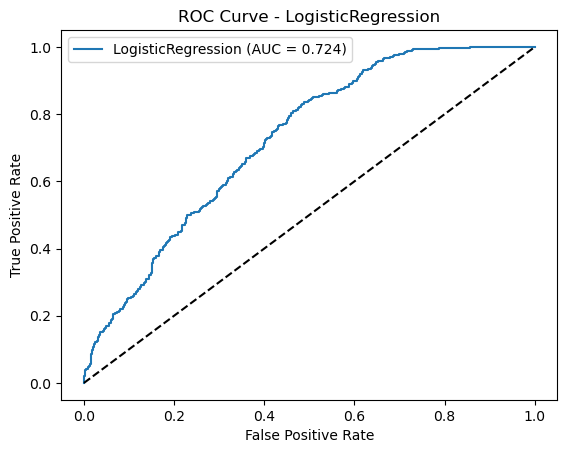

Running RandomForest
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for RandomForest:
{'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.863

Test classification report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       780
           1       0.69      0.57      0.62       350

    accuracy                           0.79      1130
   macro avg       0.76      0.73      0.74      1130
weighted avg       0.78      0.79      0.78      1130

Test ROC AUC: 0.8463186813186814
Confusion matrix:
[[690  90]
 [150 200]]


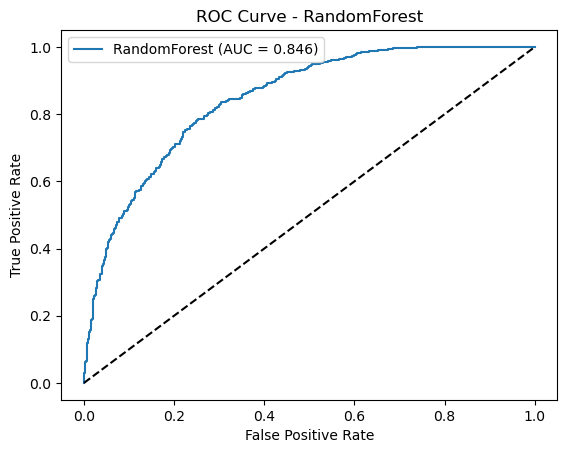

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.857

Test classification report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       780
           1       0.68      0.55      0.61       350

    accuracy                           0.78      1130
   macro avg       0.75      0.72      0.73      1130
weighted avg       0.77      0.78      0.77      1130

Test ROC AUC: 0.8430750915750915
Confusion matrix:
[[689  91]
 [158 192]]


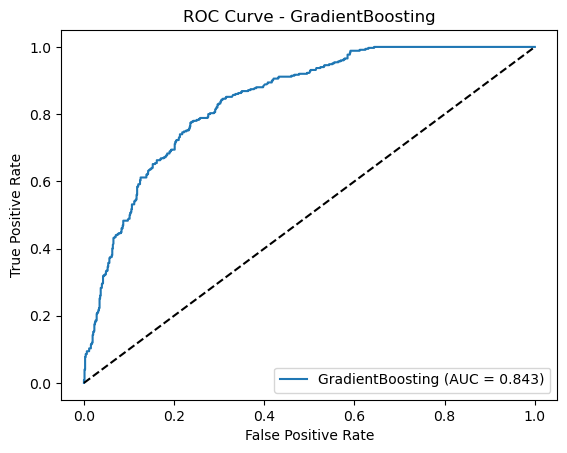

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 25, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.811

Test classification report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       780
           1       0.69      0.48      0.56       350

    accuracy                           0.77      1130
   macro avg       0.74      0.69      0.70      1130
weighted avg       0.76      0.77      0.76      1130

Test ROC AUC: 0.8137161172161173
Confusion matrix:
[[704  76]
 [183 167]]


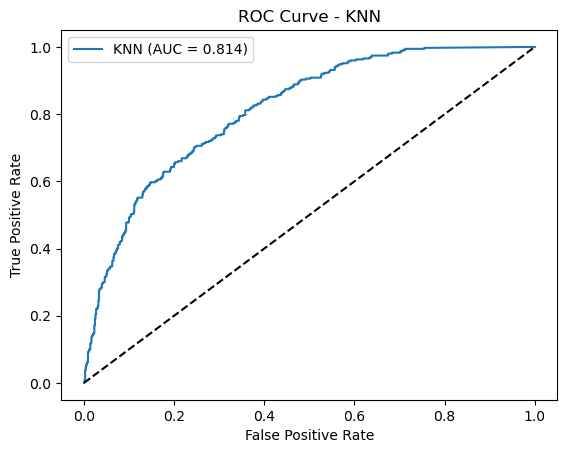

Running SVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for SVC:
{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.825

Test classification report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       780
           1       0.59      0.72      0.65       350

    accuracy                           0.76      1130
   macro avg       0.73      0.75      0.73      1130
weighted avg       0.78      0.76      0.76      1130

Test ROC AUC: 0.8235641025641026
Confusion matrix:
[[606 174]
 [ 98 252]]


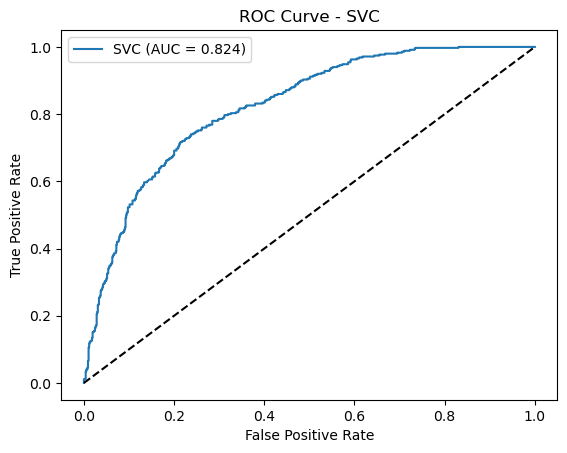

Selected value classifier: RandomForest (CV ROC AUC = 0.863, test ROC AUC = 0.846)


In [6]:

classifiers = {}

log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
log_reg_grid = {"clf__C": [0.01, 0.1, 1, 10], "clf__class_weight": [None, "balanced"]}
classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_grid)

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])
rf_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": [None, "balanced"],
}
classifiers["RandomForest"] = (rf_pipe, rf_grid)

gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5],
}
classifiers["GradientBoosting"] = (gb_pipe, gb_grid)

knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
knn_grid = {"clf__n_neighbors": [5, 15, 25], "clf__weights": ["uniform", "distance"]}
classifiers["KNN"] = (knn_pipe, knn_grid)

svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])
svc_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"],
}
classifiers["SVC"] = (svc_pipe, svc_grid)

best_classifiers = {}
cv_best_scores = {}
test_metrics = {}
cv_results_dict = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)
    grid.fit(Xc_train, yc_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_
    best_model = grid.best_estimator_
    best_classifiers[name] = best_model
    cv_results_dict[name] = pd.DataFrame(grid.cv_results_)

    y_pred = best_model.predict(Xc_test)
    y_proba = best_model.predict_proba(Xc_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(yc_test, y_pred))
    auc = roc_auc_score(yc_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(yc_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    fpr, tpr, _ = roc_curve(yc_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

best_cls_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_cls_name]
print(
    f"Selected value classifier: {best_cls_name} "
    f"(CV ROC AUC = {cv_best_scores[best_cls_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_cls_name]['roc_auc']:.3f})"
)



## Regression models (MD_EARN_WNE_P10) — CV R²


Running RandomForestRegressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params for RandomForestRegressor:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV R²: 0.607

Test R²: 0.5693477666786926
Test RMSE: 10445.250432361703


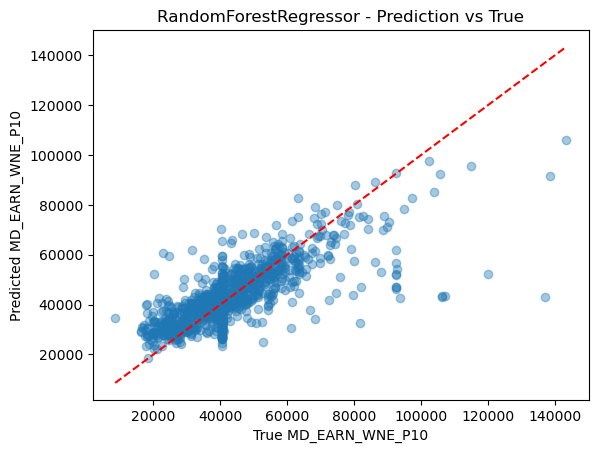

Running GradientBoostingRegressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoostingRegressor:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Best CV R²: 0.598

Test R²: 0.5767040945153765
Test RMSE: 10355.654176101412


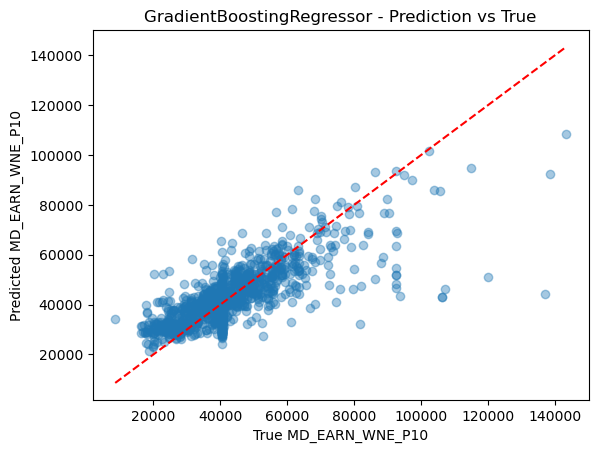

Running ElasticNet
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.497e+09, tolerance: 9.165e+07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+09, tolerance: 8.858e+07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.937e+09, toler


Best params for ElasticNet:
{'clf__alpha': 0.1, 'clf__l1_ratio': 0.9}
Best CV R²: 0.486

Test R²: 0.4472116845292262
Test RMSE: 11834.091758828408


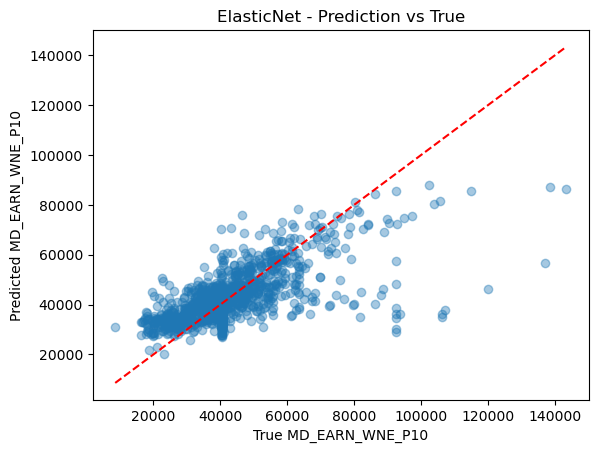

Running SVR
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best params for SVR:
{'clf__C': 10, 'clf__epsilon': 0.2, 'clf__gamma': 'auto'}
Best CV R²: 0.083

Test R²: 0.09274000754860312
Test RMSE: 15160.774396182818


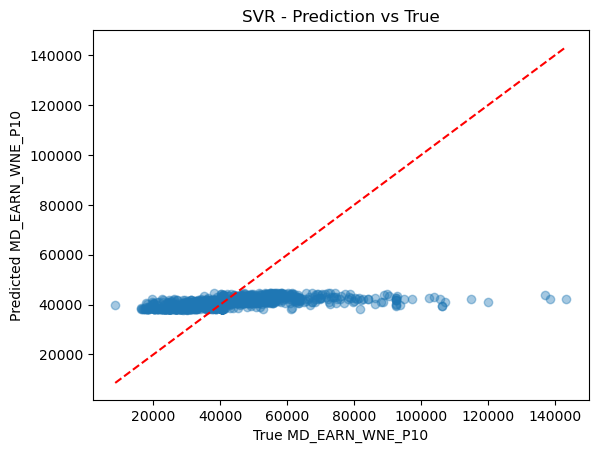

Selected main earnings model: RandomForestRegressor (CV R² = 0.607, test R² = 0.569, test RMSE = 10445.250)


In [7]:

regressors = {}

rf_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestRegressor(random_state=42))
])
rf_reg_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}
regressors["RandomForestRegressor"] = (rf_reg, rf_reg_grid)

gb_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingRegressor(random_state=42))
])
gb_reg_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5],
}
regressors["GradientBoostingRegressor"] = (gb_reg, gb_reg_grid)

en_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", ElasticNet(max_iter=5000))
])
en_reg_grid = {
    "clf__alpha": [0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.1, 0.5, 0.9],
}
regressors["ElasticNet"] = (en_reg, en_reg_grid)

svr_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVR())
])
svr_reg_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__epsilon": [0.01, 0.1, 0.2],
}
regressors["SVR"] = (svr_reg, svr_reg_grid)

best_regressors = {}
reg_cv_best_scores = {}
reg_test_metrics = {}

for name, (pipe, param_grid) in regressors.items():
    print("="*80)
    print(f"Running {name}")
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
    grid.fit(Xr_train, yr_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores[name] = grid.best_score_
    best_model = grid.best_estimator_
    best_regressors[name] = best_model

    preds = best_model.predict(Xr_test)
    r2 = r2_score(yr_test, preds)
    rmse = mean_squared_error(yr_test, preds, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics[name] = {"r2": r2, "rmse": rmse}

    plt.figure()
    plt.scatter(yr_test, preds, alpha=0.4)
    plt.xlabel("True MD_EARN_WNE_P10")
    plt.ylabel("Predicted MD_EARN_WNE_P10")
    plt.title(f"{name} - Prediction vs True")
    plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], "r--")
    plt.show()

best_reg_name = max(reg_cv_best_scores, key=reg_cv_best_scores.get)
earnings_model = best_regressors[best_reg_name]
print(
    f"Selected main earnings model: {best_reg_name} "
    f"(CV R² = {reg_cv_best_scores[best_reg_name]:.3f}, "
    f"test R² = {reg_test_metrics[best_reg_name]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics[best_reg_name]['rmse']:.3f})"
)



## Ranking helper
Combines predicted earnings, value probability, cost, engineering, research, admission, sector, and location with user-defined weights.


In [8]:

def admission_bucket(adm):
    if pd.isna(adm):
        return "Unknown"
    if adm >= 0.70:
        return "High admit (>=70%)"
    if adm >= 0.30:
        return "Medium admit (30-70%)"
    return "Low admit (<30%)"

def rank_colleges(
    df_raw,
    feature_cols_reg,
    feature_cols_cls,
    earnings_model,
    value_model,
    user_weights,
    norm_stats,
    preferred_state=None
):
    df_scored = df_raw.copy()

    X_reg_all = df_scored[feature_cols_reg]
    X_cls_all = df_scored[feature_cols_cls]

    df_scored["earn_pred"] = earnings_model.predict(X_reg_all)
    if value_model is not None:
        df_scored["p_value_model"] = value_model.predict_proba(X_cls_all)[:, 1]
    else:
        df_scored["p_value_model"] = 0.5

    def score_with_stats(col_name, out_col, invert=False):
        if col_name in df_scored.columns and col_name in norm_stats:
            vals = minmax_with_stats(df_scored[col_name].astype(float), norm_stats[col_name])
            df_scored[out_col] = 1 - vals if invert else vals
        else:
            df_scored[out_col] = 0.5

    score_with_stats("COSTT4_A", "cost_score", invert=True)
    score_with_stats("ENG_RATIO", "eng_score")
    score_with_stats("QUALITY_SCORE", "research_score")
    score_with_stats("ADM_RATE", "adm_score")
    if TARGET in norm_stats:
        df_scored["earn_score"] = minmax_with_stats(df_scored["earn_pred"], norm_stats[TARGET])
    else:
        df_scored["earn_score"] = 0.5

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if preferred_state is not None and "STABBR" in df_scored.columns:
        df_scored["location_score"] = (df_scored["STABBR"] == preferred_state).astype(float)
    else:
        df_scored["location_score"] = 0.5

    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_research = user_weights.get("research", 0)
    w_earn    = user_weights.get("earnings", 0)
    w_loc     = user_weights.get("location", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)
    w_adm     = user_weights.get("admission", 0)

    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_research + w_earn + w_loc + w_public + w_private + w_adm
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_research * df_scored["research_score"] +
        w_earn  * df_scored["earn_score"] +
        w_loc   * df_scored["location_score"] +
        w_adm   * (1 - df_scored["adm_score"]) +
        sector_component
    ) / total_w

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    if "ADM_RATE" in df_scored.columns:
        ranked["ADM_BUCKET"] = df_scored["ADM_RATE"].apply(admission_bucket)

    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "earn_pred", "COSTT4_A", "ENG_RATIO", "p_value_model", "USER_SCORE", "ADM_BUCKET"
    ]
    cols_to_show = [c for c in cols_to_show if c in ranked.columns]
    return ranked[cols_to_show]



## Example ranking
Set your preferred state (or None) and adjust weights.


In [9]:

example_weights = {
    "value_model": 2,
    "cost": 4,
    "engineering": 3,
    "research": 3,
    "earnings": 5,
    "location": 2,
    "prefer_public": 2,
    "prefer_private": 0,
    "admission": 1,
}

preferred_state_example = "FL"  # or None

ranked = rank_colleges(
    df_raw=df,
    feature_cols_reg=feature_cols_reg,
    feature_cols_cls=feature_cols_cls,
    earnings_model=earnings_model,
    value_model=value_model,
    user_weights=example_weights,
    norm_stats=norm_stats,
    preferred_state=preferred_state_example,
)

ranked.head(20)



,INSTNM,CITY,STABBR,earn_pred,COSTT4_A,ENG_RATIO,p_value_model,USER_SCORE,ADM_BUCKET
579,University of Florida,Gainesville,FL,75050.722900,21719.0,0.138414,0.401012,0.625639,Low admit (<30%)
578,Florida State University,Tallahassee,FL,63788.005143,23683.0,0.038504,0.848286,0.622634,Low admit (<30%)
572,Florida International University,Miami,FL,60013.692261,20556.0,0.073993,0.891119,0.612898,Medium admit (30-70%)
2081,United States Merchant Marine Academy,Kings Point,NY,53499.743960,9547.0,0.520500,0.735665,0.608093,Medium admit (30-70%)
5015,University of Florida-Online,Gainesville,FL,57575.194496,17036.0,0.000000,0.850859,0.607401,Medium admit (30-70%)
640,University of South Florida,Tampa,FL,59981.717501,22301.0,0.056706,0.824393,0.607336,Medium admit (30-70%)
552,University of Central Florida,Orlando,FL,61176.331466,22819.0,0.083300,0.739401,0.605598,Medium admit (30-70%)
658,University of West Florida,Pensacola,FL,57259.344811,18504.0,0.056011,0.852274,0.598995,Medium admit (30-70%)
614,University of North Florida,Jacksonville,FL,56558.199699,20229.0,0.060906,0.906095,0.596107,Medium admit (30-70%)
697,Georgia Institute of Technology-Main Campus,Atlanta,GA,91370.832385,27797.0,0.464600,0.189359,0.594205,Low admit (<30%)


## Interactive sliders for weights
Drag sliders to adjust weights and choose state; reruns ranking and shows top 10.


In [ ]:

import ipywidgets as widgets
from IPython.display import display, clear_output

states = sorted(df["STABBR"].dropna().unique())
state_dropdown = widgets.Dropdown(options=[None]+states, description='State')

slider_cfg = {
    "value_model": widgets.IntSlider(value=2, min=0, max=5, description='Value'),
    "cost": widgets.IntSlider(value=4, min=0, max=5, description='Cost'),
    "engineering": widgets.IntSlider(value=3, min=0, max=5, description='Eng'),
    "research": widgets.IntSlider(value=3, min=0, max=5, description='Research'),
    "earnings": widgets.IntSlider(value=5, min=0, max=5, description='Earnings'),
    "location": widgets.IntSlider(value=2, min=0, max=5, description='Location'),
    "prefer_public": widgets.IntSlider(value=2, min=0, max=5, description='Public'),
    "prefer_private": widgets.IntSlider(value=0, min=0, max=5, description='Private'),
    "admission": widgets.IntSlider(value=1, min=0, max=5, description='Admission'),
}

go_button = widgets.Button(description='Rank', button_style='primary')
out = widgets.Output()

@go_button.on_click
def on_click(btn):
    weights = {k: w.value for k, w in slider_cfg.items()}
    preferred_state = state_dropdown.value
    ranked = rank_colleges(
        df_raw=df,
        feature_cols_reg=feature_cols_reg,
        feature_cols_cls=feature_cols_cls,
        earnings_model=earnings_model,
        value_model=value_model,
        user_weights=weights,
        norm_stats=norm_stats,
        preferred_state=preferred_state,
    )
    with out:
        clear_output()
        display(ranked.head(10))

controls = widgets.VBox(list(slider_cfg.values()) + [state_dropdown, go_button])
display(widgets.HBox([controls, out]))

